In [153]:
import networkx as nx
import random
import matplotlib.pyplot as plt
import numpy as np

In [154]:
def generate_exchange_matrix(size: int, graph: nx.graph) -> list:
    """ノード間の通信コストを表す交流行列を作成

    Args:
        size (int): 行列のサイズ size x size
        graph: ネットワークトポロジ- (networkxのグラフ)
    Returns:
        list: n x nの正方行列
    """
    
    # graphの隣接リストを取得
    adj_list = nx.to_dict_of_lists(graph)
    # 通信コストの行列を作成
    matrix = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            # 自身との通信は0
            if i == j:
                matrix[i][j] = 0
            # 隣接している場合は1~100の乱数(通信コストを与える)
            # (j+1)が隣接リストの(i+1)番目の要素(配列)に含まれているかどうかで判定
            elif j + 1 in adj_list[i + 1]:
                matrix[i][j] = random.randint(1, 100)
            # 隣接していない場合は-1(通信できないので)
            else:
                matrix[i][j] = -1

    # 対称性を持たせる
    for i in range(size):
        for j in range(size):
            if i < j:
                matrix[i][j] = matrix[j][i]
                

    for i in range(size):
        for j in range(size):
            if j+1 in adj_list[i+1]:
                graph.add_edge(i+1, j+1, weight=matrix[i][j])
    
    return matrix

In [155]:
def generate_random_circular_graph(num_nodes: int)-> nx.Graph:
    """ネットワークトポロジーを表すグラフを作成

    Args:
        num_nodes (int): ノードの数

    Returns:
        nx.Graph: トポロジーを表すグラフ
    """
    
    G = nx.Graph()  # Create an empty graph

    # Add nodes to the graph
    G.add_nodes_from(range(1, num_nodes+1))
    
    # Connect edges randomly for circular structure
    for i in range(1, num_nodes+1):
        G.add_edge(i, i % num_nodes + 1)

    # Connect additional random inside edges
    for i in range(1, num_nodes+1):
        for j in range(i+1, num_nodes+1):
            if random.random() < 0.5:  # Probability of connecting two nodes
                G.add_edge(i, j)

    return G

In [156]:
def weightintg_graph(graph: nx.graph, exchange_matrix: list):
    """グラフに重み付け(通信コスト)を与える

    Args:
        graph (nx.graph): 重み付きグラフ(トポロジー)
        exchange_matrix (list): 通信コストを表す交流行列
    """
    
    num_nodes = len(exchange_matrix)
    adj_list = nx.to_dict_of_lists(graph)
    
    for i in range(num_nodes):
        for j in range(num_nodes):
            if j+1 in adj_list[i+1]:
                graph.add_edge(i+1, j+1, weight=exchange_matrix[i][j])

In [157]:
def create_block_matrix(num_rows: int, num_cols: int) -> list:
    """ニューラルネットワークを分割したブロックの接続関係を表す行列を作成

    Args:
        num_rows (int): 分割ブロックの行数
        num_cols (int): 分割ブロックの列数

    Returns:
        list: ブロック間の接続を表す行列
        
    Example:
        num_rows = 2, num_cols = 3の場合
        -----
        1 3 5
        2 4 6
        -----
        
        となり接続関係は以下のようになる
        接続関係を持っていれば1, なければ0
        --------------------
        [[0, 1, 1, 1, 0, 0],
        [1, 0, 1, 1, 0, 0],
        [1, 1, 0, 1, 1, 1],
        [1, 1, 1, 0, 1, 1],
        [0, 0, 1, 1, 0, 1],
        [0, 0, 1, 1, 1, 0]]
        --------------------
    """
    matrix_size = num_rows * num_cols
    matrix = [[0] * matrix_size for _ in range(matrix_size)]

    # Helper function to check if a block is within the matrix bounds
    def is_valid_block(row, col):
        return 0 <= row < num_rows and 0 <= col < num_cols

    # Iterate over each block in depth-first order
    for block in range(matrix_size):
        col = block // num_rows
        row = block % num_rows

        # Connect to vertical neighbors
        if is_valid_block(row - 1, col):
            neighbor = (col * num_rows) + (row - 1)
            matrix[block][neighbor] = 1
            matrix[neighbor][block] = 1
        if is_valid_block(row + 1, col):
            neighbor = (col * num_rows) + (row + 1)
            matrix[block][neighbor] = 1
            matrix[neighbor][block] = 1

        # Connect to horizontal neighbors
        if is_valid_block(row, col - 1):
            neighbor = ((col - 1) * num_rows) + row
            matrix[block][neighbor] = 1
            matrix[neighbor][block] = 1
        if is_valid_block(row, col + 1):
            neighbor = ((col + 1) * num_rows) + row
            matrix[block][neighbor] = 1
            matrix[neighbor][block] = 1

        # Connect to diagonal neighbors
        if is_valid_block(row - 1, col - 1):
            diagonal_neighbor = ((col - 1) * num_rows) + (row - 1)
            matrix[block][diagonal_neighbor] = 1
            matrix[diagonal_neighbor][block] = 1
        if is_valid_block(row - 1, col + 1):
            diagonal_neighbor = ((col + 1) * num_rows) + (row - 1)
            matrix[block][diagonal_neighbor] = 1
            matrix[diagonal_neighbor][block] = 1
        if is_valid_block(row + 1, col - 1):
            diagonal_neighbor = ((col - 1) * num_rows) + (row + 1)
            matrix[block][diagonal_neighbor] = 1
            matrix[diagonal_neighbor][block] = 1
        if is_valid_block(row + 1, col + 1):
            diagonal_neighbor = ((col + 1) * num_rows) + (row + 1)
            matrix[block][diagonal_neighbor] = 1
            matrix[diagonal_neighbor][block] = 1

    return matrix


In [158]:
def generate_block_list(num_blocks: int) -> list:
    """分割したブロックの番号リスト

    Args:
        num_nodes (int): 分割ブロックの数

    Returns:
        list: ブロックの番号リスト
        
    Example:
        num_blocks = 6の場合
        ------------------
        [0, 1, 2, 3, 4, 5]
        ------------------
    """    
    block_list = []
    for i in range(num_blocks):
        block_list.append(i)
    return block_list

In [159]:
def generate_assignment_block_list(num_pcs: int, num_blocks: int) -> list:
    """計算機が担当するブロックを表す行列

    Args:
        num_pcs (int): 計算機の数
        num_blocks (int): ブロックの数

    Returns:
        list: 計算機が担当するブラックを表す行列
        
    Example:
        num_pcs = 4, num_blocks = 6の場合
        [[1, 0, 0, 0, 1, 0],
         [0, 1, 0, 0, 0, 1],
         [0, 0, 1, 0, 0, 0],
         [0, 0, 0, 1, 0, 0]]
        
        PC1 -> 0, 4のブロックを担当
        PC2 -> 1, 5のブロックを担当
        PC3 -> 2のブロックを担当
        PC4 -> 3のブロックを担当
    """    
    matrix = [[0] * num_blocks for _ in range(num_pcs)]

    # Distribute tasks to computers
    for task in range(num_blocks):
        computer = task % num_pcs
        matrix[computer][task] = 1

    return matrix

交流行列
[[ 0. 82. -1. 57.]
 [82.  0. 81. -1.]
 [-1. 81.  0. 60.]
 [57. -1. 60.  0.]]

ニューラルネットワークの分割ブロックの接続関係を表す行列
[[0, 1, 1, 1, 0, 0],
 [1, 0, 1, 1, 0, 0],
 [1, 1, 0, 1, 1, 1],
 [1, 1, 1, 0, 1, 1],
 [0, 0, 1, 1, 0, 1],
 [0, 0, 1, 1, 1, 0]]

分割ブロックの番号リスト
[0, 1, 2, 3, 4, 5]

PCが担当するブロックの割り当て行列
[1, 0, 0, 0, 1, 0]
[0, 1, 0, 0, 0, 1]
[0, 0, 1, 0, 0, 0]
[0, 0, 0, 1, 0, 0]


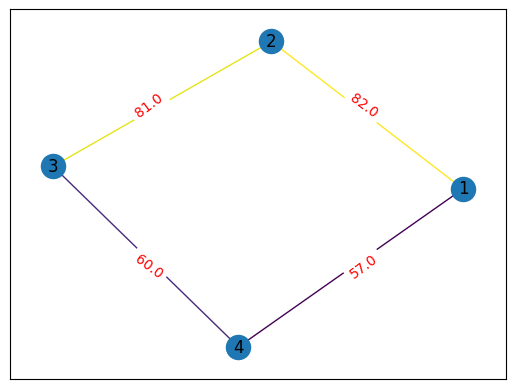

In [161]:
# ネットワークトポロジーを作成
G = generate_random_circular_graph(4)

# 交流行列を作成
exchange_matrix = generate_exchange_matrix(4, G)

# グラフのエッジに通信コスト(交流行列より)を付与
weightintg_graph(G, exchange_matrix)

# グラフの描画
pos = nx.circular_layout(G)
weights = nx.get_edge_attributes(G, 'weight').values()
nx.draw_networkx(G, edge_color = weights)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

print("交流行列")
print(exchange_matrix)

matrix = create_block_matrix(2, 3)
print("\nニューラルネットワークの分割ブロックの接続関係を表す行列")
pprint.pprint(matrix)

block_list = generate_block_list(6)
print("\n分割ブロックの番号リスト")
print(block_list)

# Distribute tasks to computers
task_matrix = generate_assignment_block_list(4, 6)

print("\nPCが担当するブロックの割り当て行列")
# Print the task matrix
for row in task_matrix:
    print(row)